In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
from isaac.dataset import read_dataset, prepare_dataset, sample_subsequences, split_in_subsequences, add_mouse_columns_to_passive_trials
from isaac.utils import plot_confusion_matrix
from isaac.models import RNNModel, ComplexRNNModel, initialise_model
from isaac.constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS, YOKED_TRAINING_COLS, MOUSE_COLS
from isaac.training import evaluate, training_loop, evaluate_saved_model
from isaac.sanity import class_proportions

In [4]:
BATCH_SIZE = 128
EPOCHS = 60
NORMALISE_DATA = True
STEP_SIZE = 2
SEQ_END = 1800

# Define common model, loss and optimizer

In [5]:
INPUT_DIM = len(YOKED_TRAINING_COLS)    # input dimension
HIDDEN_DIM = 32  # hidden layer dimension
N_LAYERS = 4     # number of hidden layers
OUTPUT_DIM = 3   # output dimension
DROPOUT = 0.7

network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)

In [6]:
exp1_trials = read_dataset("data/yoked_trials_exp1.h5")
exp2_mass_trials = read_dataset("data/mass_trials_exp2.h5")
exp2_force_trials = read_dataset("data/force_trials_exp2.h5")

first_half = [trial[:1801] for trial in exp1_trials]
second_half = [trial[-1801:] for trial in exp1_trials]

exp1_trials = first_half + second_half

yoked_trials = exp1_trials + exp2_force_trials + exp2_mass_trials

100%|██████████| 399/399 [00:07<00:00, 56.64it/s]


In [7]:
for trial in tqdm(yoked_trials):
    trial.mouseX = trial.mouseX * (trial.idControlledObject != "none").astype(int)
    trial.mouseY = trial.mouseY * (trial.idControlledObject != "none").astype(int)

100%|██████████| 1084/1084 [00:11<00:00, 91.06it/s] 


yoked_trials = split_in_subsequences(yoked_trials, seq_size=600)

In [8]:
np.random.seed(0)
indices = np.arange(len(yoked_trials))
test_indices = np.random.choice(indices, 100, replace=False)
val_indices = np.random.choice(list(set(indices) - set(test_indices)), 100, replace=False)
train_indices = list(set(indices) - set(test_indices) - set(val_indices))

train_trials = [yoked_trials[i] for i in train_indices]
val_trials = [yoked_trials[i] for i in val_indices]
test_trials = [yoked_trials[i] for i in test_indices]

In [9]:
passive_trials = read_dataset("data/train_passive_trials.h5", n_trials=800)

100%|██████████| 800/800 [00:04<00:00, 199.44it/s]


In [11]:
passive_trials = add_mouse_columns_to_passive_trials(passive_trials)
passive_trials = [trial[:1801] for trial in passive_trials]

In [12]:
train_trials += passive_trials

train_trials = exp2_force_trials + first_half
val_trials = exp2_mass_trials
test_trials = second_half

In [13]:
len(train_trials), len(val_trials), len(test_trials)

(1684, 100, 100)

# FORCE TRAINING  (Humans achieve 63% +- 21%)

## Read dataset and preprocess it

In [14]:
loaders, scaler = prepare_dataset([train_trials, val_trials, test_trials], class_columns=FORCE_CLASS_COLS, 
                                  training_columns=YOKED_TRAINING_COLS,
                                  batch_size=BATCH_SIZE, normalise_data=NORMALISE_DATA)

100%|██████████| 100/100 [00:00<00:00, 286.77it/s]


In [15]:
train_loader, val_loader, test_loader = loaders

In [16]:
class_proportions(train_loader)
print()
class_proportions(val_loader)
print()
class_proportions(test_loader)

[567 597 520]
Majority class:  0.35451306413301664

[33 41 26]
Majority class:  0.41

[36 37 27]
Majority class:  0.37


## Define model, loss and optimizer

In [18]:
model, error, optimizer = initialise_model(network_dims, DROPOUT, lr=0.01)

## Train model and plot loss and accuracy

In [19]:
model.train()
epoch_losses, epoch_accuracies, best_model = training_loop(model, optimizer, error, train_loader, val_loader, 
                                                           EPOCHS, seq_end=SEQ_END, step_size=STEP_SIZE)

Train_loss (0.59)	 Train_acc (66.92)	 Val_acc (40.00):  58%|█████▊    | 35/60 [02:21<01:41,  4.06s/it]

KeyboardInterrupt: 

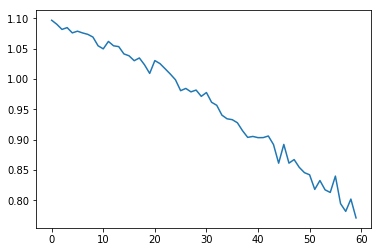

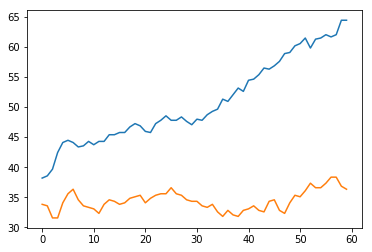

In [15]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [16]:
max(epoch_accuracies[1])

38.34586466165413

## Save model and scaler

In [17]:
torch.save(best_model.state_dict(), "models/yoked_force_model.pt")
joblib.dump(scaler, "scalers/yoked_force_scaler.sk")

['scalers/yoked_force_scaler.sk']

## Evaluate saved model

100%|██████████| 100/100 [00:00<00:00, 302.86it/s]


Model's accuracy on test set: 36.0


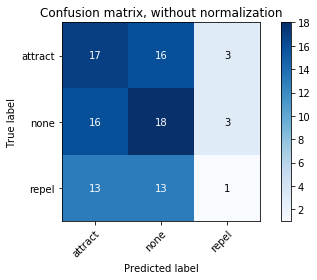

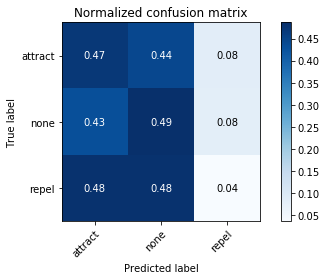

In [18]:
model_path = "models/yoked_force_model.pt"
scaler_path = "scalers/yoked_force_scaler.sk"
network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT)
class_columns = FORCE_CLASS_COLS

evaluate_saved_model(model_path, network_dims, None, YOKED_TRAINING_COLS,
                     class_columns=class_columns, step_size=2, scaler_path=scaler_path, trials=test_trials)

# MASS TRAINING (Humans achieve 45% +- 20%)

## Read dataset and preprocess it

scaler = joblib.load("scalers/passive_mass_scaler.sk")

In [19]:
loaders, scaler = prepare_dataset([train_trials, val_trials, test_trials], training_columns=YOKED_TRAINING_COLS, 
                                  class_columns=MASS_CLASS_COLS, batch_size=BATCH_SIZE, 
                                  normalise_data=NORMALISE_DATA)

100%|██████████| 100/100 [00:00<00:00, 276.27it/s]


In [20]:
train_loader, val_loader, test_loader = loaders

In [21]:
class_proportions(train_loader)
class_proportions(val_loader)
class_proportions(test_loader)

[312 262 310]
Majority class:  0.35294117647058826
[38 27 35]
Majority class:  0.38
[34 28 38]
Majority class:  0.38


## Define model, loss and optimizer

## Train model and plot loss and accuracy

In [22]:
network_dims = network_dims[:-1]

In [23]:
network_dims

(23, 32, 4, 3)

In [24]:
model, error, optimizer = initialise_model(network_dims, DROPOUT, lr=0.001)

In [25]:
epoch_losses, epoch_accuracies, best_model = training_loop(model, optimizer, error, train_loader, val_loader, EPOCHS, 
                                                           step_size=STEP_SIZE)

Train_loss (0.89)	 Train_acc (59.28)	 Val_acc (40.00): 100%|██████████| 60/60 [02:57<00:00,  2.98s/it]


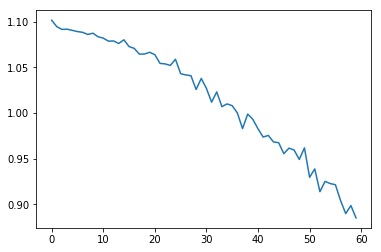

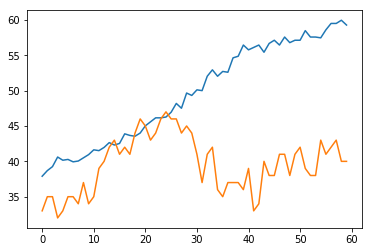

In [26]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [27]:
max(epoch_accuracies[1])

47.0

## Save model and scaler

In [28]:
torch.save(best_model.state_dict(), "models/yoked_mass_model.pt")
joblib.dump(scaler, "scalers/yoked_mass_scaler.sk")

['scalers/yoked_mass_scaler.sk']

## Load model and evaluate

100%|██████████| 100/100 [00:00<00:00, 264.05it/s]


Model's accuracy on test set: 41.0


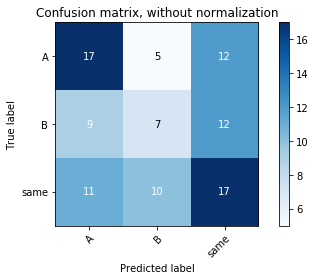

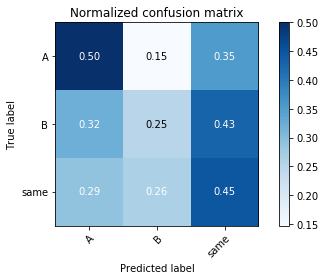

In [29]:
model_path = "models/yoked_mass_model.pt"
scaler_path = "scalers/yoked_mass_scaler.sk"
network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)
class_columns = MASS_CLASS_COLS

evaluate_saved_model(model_path, network_dims, None, YOKED_TRAINING_COLS,
                     class_columns, step_size=STEP_SIZE, scaler_path=scaler_path, trials=test_trials)